## Train ResNets

### created by Yuying Liu, 04/30/2020

This script is a template for training neural network time-steppers for different systems and different time scales. To reproduce the results in the paper, one needs to obtain all 11 neural network models for each nonlinear system under study. For setup details, please refer to Table 2 in the paper.

In [1]:
import os
import sys
import torch
import numpy as np

 
module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [2]:
# adjustables

k = 1                        # model index: should be in {0, 2, ..., 10}
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'VanDerPol'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epoch = 100000            # the maximum training epoch 
batch_size = 320              # training batch size
# arch = [2, 128, 128, 128, 2]  # architecture of the neural network

if system == 'KS' or system == "KS_new":
    smallest_step = 1
    dt = 0.025
    arch = [512, 2048, 512]
elif system == "VanDerPol":
    smallest_step = 4
    dt = 0.01
    arch = [2, 512, 512, 512, 2]
elif system == "Lorenz":
    smallest_step = 16
    dt = 0.0005
    arch = [3, 1024, 1024, 1024, 3]
else:
    print("system not available")
    raise SystemExit()

In [3]:
# paths
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
n_forward = 5
step_size = 2**k

In [4]:
# load data
train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
try:
    val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
except:
    val_data = train_data
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
n_train = train_data.shape[0]
n_val = val_data.shape[0]
n_test = test_data.shape[0]

step_size = 300
# create dataset object
dataset = net.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)

torch.Size([3200, 5, 2])


(0.0, 2000.0)

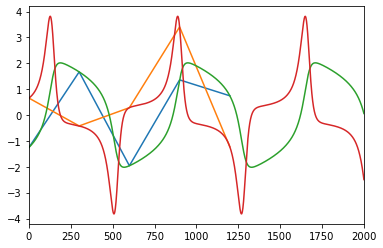

In [5]:
import matplotlib.pyplot as plt
print(dataset.train_ys.shape)
plt.plot(np.arange(5) * step_size, dataset.train_ys[0,:])
plt.plot(train_data[0, step_size:])
plt.xlim([0,2000])

torch.Size([3200, 5, 2])


(0.0, 2000.0)

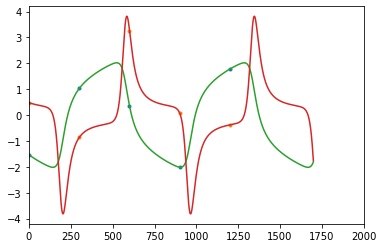

In [8]:
dataset = net.DataSet(train_data, val_data, test_data, dt, step_size, n_forward, True)

import matplotlib.pyplot as plt
print(dataset.train_ys.shape)
plt.plot(np.arange(5) * step_size, dataset.train_ys[0,:], '.')
plt.plot(train_data[0, -300:-2000:-1])
plt.xlim([0,2000])


In [8]:
model_name = 'original_model_D{}_noise{}.pt'.format(step_size, noise)

# create/load model object
try:
    bjk
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = torch.load(os.path.join(model_dir, model_name), map_location=device)
    model.device = device
except:
    print('create model {} ...'.format(model_name))
    model = net.ResNet(arch=arch, dt=dt, step_size=step_size)

# training
model.train_net(dataset, max_epoch=max_epoch, batch_size=batch_size, lr=lr,
                model_path=os.path.join(model_dir, model_name))

create model original_model_D2_noise0.0.pt ...
time for first 10 =  2.373335599899292
epoch 1000, training loss 0.008201147429645061, validation loss 0.008017415180802345
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.003585575148463249, validation loss 0.0035567893646657467
(--> new model saved @ epoch 2000)


KeyboardInterrupt: 